In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd
import random
from sklearn.neighbors import NearestNeighbors

%load_ext autoreload
%autoreload 2 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Neighbor Search

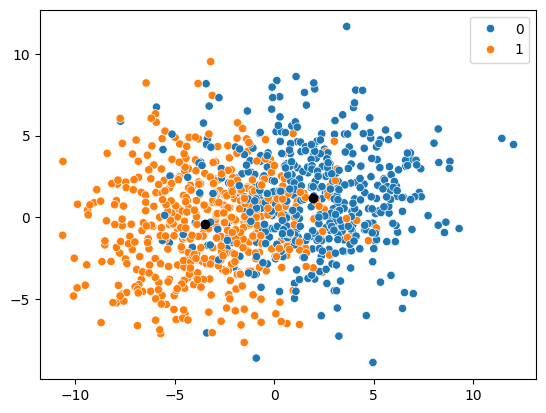

In [4]:
X, y, centers = make_blobs(centers=2, cluster_std=3, n_features=2, n_samples=1000, return_centers=True)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.scatter(x=centers[0][0], y=centers[0][1],color="black")
plt.scatter(x=centers[1][0], y=centers[1][1],color="black")

In [5]:
km = KMeans(2).fit(X)
pred_hue = km.labels_

In [6]:
def neighborSearch(
        X,
        y,
        target,
        kmeans,
        instance_index=None,
        n=8,
        dis = lambda a,b : np.linalg.norm(a-b)):
    df = pd.DataFrame(np.column_stack((X, y)), columns=[f'x{i}' for i in range(X.shape[1])] + ['label'], dtype=float)
    predictor = lambda z : kmeans.predict(np.array([z]))

    pred_instance = 0.0
    if instance_index == None:
        instance_index = random.randint(0,len(df.values))
        new_instance = df.values[instance_index][:-1]
        pred_instance = predictor(new_instance)
        if pred_instance == 1.0:
            target = 0.0
        else:
            target = 1.0
    else:
        new_instance = df.values[instance_index][:-1]
        pred = predictor(new_instance)
        pred_instance = pred
        if pred == target:
            raise Exception("Faulty instance were given, target does not match")


    target_points = np.array((df[df["label"] == target]).values)[:,:-1]
    instance = df.values[instance_index][:-1]

    neigh = NearestNeighbors(n_neighbors=n)
    neigh.fit(target_points)
    neighbors = neigh.kneighbors([instance], n, return_distance=False)
    neighbors = target_points[neighbors[0]]
    print(target, instance)
    
    counterfactuals = np.empty((0,2))
    for neighbor in neighbors:
        cf = instance.copy()
        changed_features = []

        while True:
            max_change = -float('inf')
            least_change = float('inf')
            max_feature = -1
            least_feature = -1

            for f in range(len(neighbor)):
                if f in changed_features:
                    continue
                temp_cf = cf.copy()
                temp_cf[f] = neighbor[f]
                f_dis = dis(temp_cf, neighbor)
                diff = np.abs(neighbor[f] - cf[f])
                score = f_dis / diff
                
                if predictor(temp_cf) != pred_instance:
                    if score < least_change:
                        least_change = score
                        least_feature = f
                    continue
                
                if score > max_change:
                    max_change = score
                    max_feature = f

            if max_feature == -1:
                cf[least_feature] = neighbor[least_feature]
                break
            else:
                changed_features.append(max_feature)
                cf[max_feature] = neighbor[max_feature]

        counterfactuals = np.append(counterfactuals, np.array([cf]), axis=0)

    return instance,counterfactuals


In [7]:
x, cfs = neighborSearch(X, pred_hue,1.0,km)
cfs

1.0 [-4.69350848 -4.28302558]


array([[ 0.0652275 , -2.54774628],
       [ 0.04353599, -2.42616313],
       [-0.12984159, -1.93811611],
       [ 0.1122383 , -2.41527527],
       [ 0.37511721, -3.07617107],
       [-0.34657998, -1.13065036],
       [-0.36124665, -1.09825029],
       [-0.24552946, -1.2127009 ]])

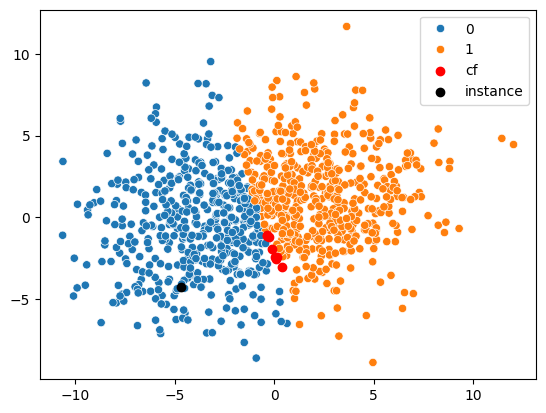

In [8]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=pred_hue)
plt.scatter(x=cfs[:,0],y=cfs[:,1],color='red', label='cf')
plt.scatter(x=x[0],y=x[1],color='black',label='instance')
plt.legend()